In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Paths to images and labels
data_path = "/Volumes/PC and Mac/Plant_net/downloaded_images_5000_2.0/"
labels_csv = "/Volumes/PC and Mac/Plant_net/image_types_5000_2.0.csv"
# Load the CSV
data = pd.read_csv(labels_csv)  # CSV has columns ['filename', 'label']

# Preprocess images
def preprocess_images(data, data_path, img_size=(128, 128)):
    images = []
    labels = []

    for i, row in data.iterrows():
        img_path = data_path + row['image_filename']
        label = row['type']

        # Load and preprocess image
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0  # Normalize
        images.append(img_array)
        labels.append(label)

    return np.array(images), np.array(labels)

# Preprocess the data
images, labels = preprocess_images(data, data_path)
print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")

2024-12-04 10:42:07.329458: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Images shape: (5000, 128, 128, 3), Labels shape: (5000,)


In [3]:
# Flatten images for Random Forest input
images_flattened = images.reshape(images.shape[0], -1)  # (num_samples, height * width * channels)

# Encode labels to integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)  # Encode class names to integers
print(f"Classes: {label_encoder.classes_}")

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images_flattened, labels_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")


Classes: ['bark' 'flower' 'fruit' 'leaf']
Training set: (3500, 49152), Validation set: (1005, 49152), Test set: (495, 49152)


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = rf_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.2f}")

Validation Accuracy: 0.75


Test Accuracy: 0.73
Classification Report:
              precision    recall  f1-score   support

        bark       0.76      0.92      0.83       211
      flower       0.67      0.78      0.72       144
       fruit       0.00      0.00      0.00        30
        leaf       0.76      0.50      0.60       110

    accuracy                           0.73       495
   macro avg       0.55      0.55      0.54       495
weighted avg       0.69      0.73      0.70       495



/Users/louise/Desktop/UNIL/machine learning/exa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/louise/Desktop/UNIL/machine learning/exa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/louise/Desktop/UNIL/machine learning/exa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

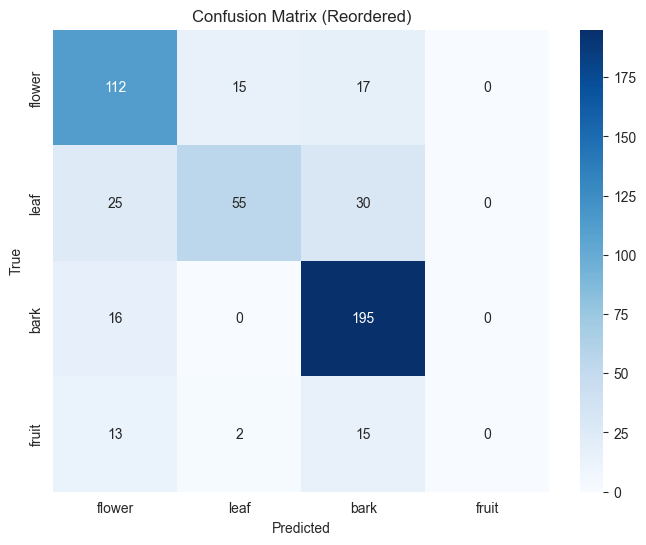

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_test_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_test_pred)

# Define the new order of labels
desired_order = ['flower', 'leaf', 'bark', 'fruit']

# Reorder the confusion matrix
reordered_indices = [label_encoder.classes_.tolist().index(label) for label in desired_order]
cm_rf = conf_matrix[reordered_indices, :][:, reordered_indices]

# Plot the reordered confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=desired_order,
    yticklabels=desired_order
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Reordered)')
plt.savefig('/Volumes/PC and Mac/Plant_net/random_forest_conf_matrix.png', dpi=300)
plt.show()


In [10]:
def calculate_mcc(cm):
    mcc_list = []
    num_classes = cm.shape[0]

    for i in range(num_classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)

        numerator = TP * TN - FP * FN
        denominator = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

        if denominator != 0:
            mcc = numerator / denominator
        else:
            mcc = 0  # If denominator is zero, MCC is undefined, so we set it to zero

        mcc_list.append(mcc)

    return np.mean(mcc_list)  # Return the mean MCC across all classes

In [11]:
# Calculate and print the Multiclass MCC
mcc_score_rf = calculate_mcc(cm_rf)
print(f"Multiclass MCC: {mcc_score_rf}")

Multiclass MCC: 0.4591063576246664


In [12]:
params = rf_model.get_params()
print(params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
